### problem 2: Finding the Most Targeted Region

In [2]:
import sklearn
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme (style="darkgrid")
print(sklearn.__version__)  # This will print the version of scikit-learn installed


1.6.1


In [3]:
# Reading the newly created dataset for K-Means
df = pd.read_csv("kmeans_dataset.csv")

kmeans_dataset = df


# Pre modelling checks and final processing

In [4]:
kmeans_dataset.head()

,target,launched,destroyed
0,NaN,1.0,1.0
1,NaN,1.0,1.0
2,Dnipro,1.0,0.0
3,NaN,1.0,1.0
4,NaN,2.0,2.0


In [11]:
len(kmeans_dataset)

1436

In [4]:
df.isnull().sum()


target       568
launched       0
destroyed      2
dtype: int64

Marking null values in target column as unkown for now

In [5]:
# Drop only 2 rows with missing destroyed values
df = df.dropna(subset=['destroyed'])

# Fill target NaNs with 'Unknown'
df.loc[:, 'target'] = df['target'].fillna('Unknown')



# Modeling K-Means

Version 1 making use of target launched and destroyed

In [6]:
# Aggregating the values first
region_stats = df.groupby('target')[['launched', 'destroyed']].sum().reset_index()

# Now each row in region_stats = 1 region with total launched/destroyed counts.

In [7]:
unknown_row = region_stats[region_stats['target'] == 'Unknown']
region_known = region_stats[region_stats['target'] != 'Unknown']


Feature scaling

In [8]:
scaler = StandardScaler()
X_known = scaler.fit_transform(region_known[['launched', 'destroyed']])

Initial clustering using 3 clusters

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
region_known.loc[:, 'cluster'] = kmeans.fit_predict(X_known)

unknown_scaled = scaler.transform(unknown_row[['launched', 'destroyed']])

/var/folders/cc/xzk8m4152gg0hn0wv4f7djc80000gn/T/ipykernel_80882/40575143.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_known.loc[:, 'cluster'] = kmeans.fit_predict(X_known)


Analysing the cluster

In [10]:
# Average value per cluster
region_known.groupby('cluster')[['launched', 'destroyed']].mean()

# Viewing the full sorted cluster list
region_known.sort_values(by='destroyed', ascending=False)

,target,launched,destroyed,cluster
61,Odesa oblast,584.0,387.0,1
47,Kyiv oblast,357.0,339.0,1
37,Kherson oblast,225.0,190.0,0
53,Mykolaiv oblast,205.0,152.0,0
63,Odesa oblast and Mykolaiv oblast,163.0,119.0,0
...,...,...,...,...
72,"Poltava oblast, Myrhorod Raion",1.0,0.0,0
35,Kharkiv oblast and Zaporizhzhia oblast,35.0,0.0,0
36,Kherson,2.0,0.0,0
42,Kramatorsk,2.0,0.0,0


Visualisation

In [11]:
# Get top 10 most destroyed regions
top10 = region_known.sort_values(by='destroyed', ascending=False).head(6)


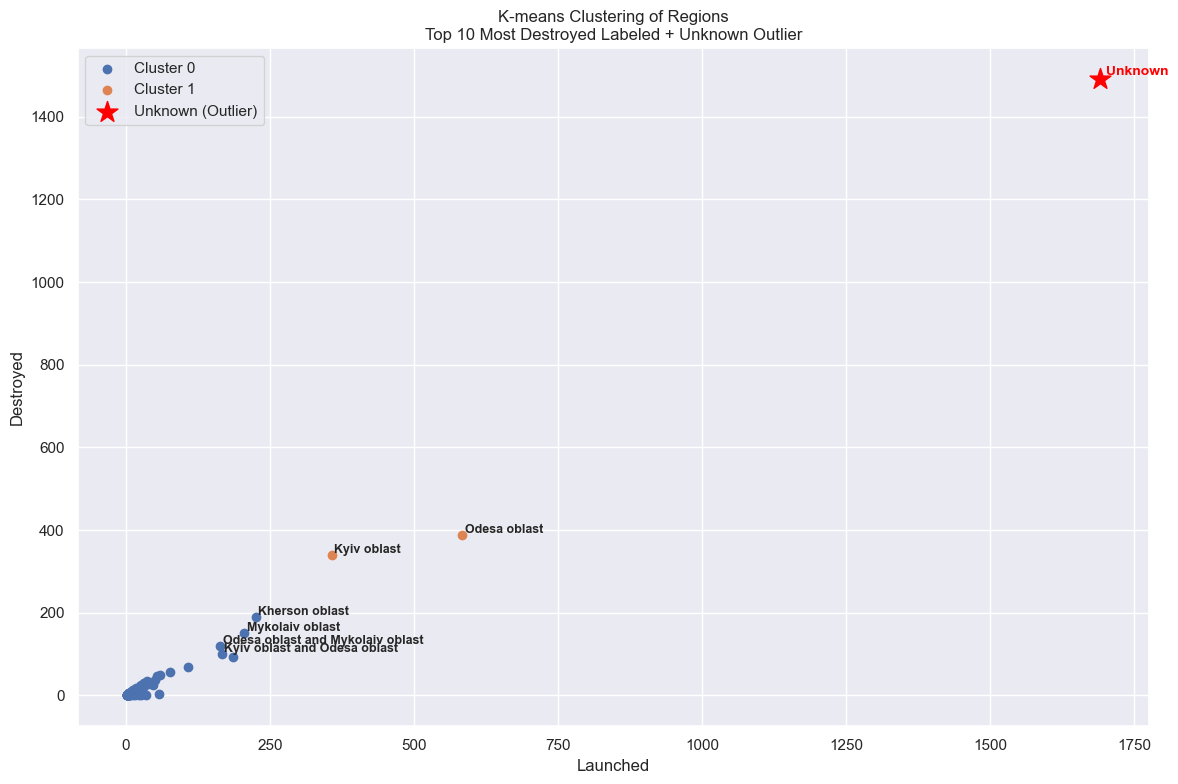

In [12]:


plt.figure(figsize=(12, 8))

# Plot clusters
for cluster in region_known['cluster'].unique():
    subset = region_known[region_known['cluster'] == cluster]
    plt.scatter(subset['launched'], subset['destroyed'], label=f'Cluster {cluster}')

# Plot Unknown separately
plt.scatter(
    unknown_row['launched'], unknown_row['destroyed'],
    color='red', marker='*', s=250, label='Unknown (Outlier)'
)

# Label only the top 10 most destroyed regions
for _, row in top10.iterrows():
    plt.text(row['launched'] + 5, row['destroyed'] + 5, row['target'], fontsize=9, fontweight='bold')

# Label the Unknown point
plt.text(
    unknown_row['launched'].values[0] + 10,
    unknown_row['destroyed'].values[0] + 10,
    'Unknown',
    fontsize=10,
    color='red',
    fontweight='bold'
)

plt.xlabel('Launched')
plt.ylabel('Destroyed')
plt.title('K-means Clustering of Regions\nTop 10 Most Destroyed Labeled + Unknown Outlier')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## V1 rough answer Odesa Oblast as most targeted region
*final K-Means graph of version 1 as 40% of the target column is NaN values I have used this version to show how this, in the next version I will try and improve the accuracy and use hot encoding for better results.*

## Version 2 using hot encoding and improved accuracy

In [13]:
# Hot encoding target for target ergion names
X = pd.get_dummies(region_known['target'], prefix='region')

# Adding numerical features
X['launched'] = region_known['launched']
X['destroyed'] = region_known['destroyed']

# Adding target variable clusters from K-Means prior
y = region_known['cluster']

#### Training the model from the K-means clusters and Hot encoded region names using random forest 

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# split into train/test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate training
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



This first random forest model was far too perfect showing the problem as a very small data pool i will re map the region names to use the full amount of rows

In [15]:
# Map cluster labels to original df
region_cluster_map = region_known.set_index('target')['cluster'].to_dict()
df['cluster'] = df['target'].map(region_cluster_map)

# Drop rows where cluster is NaN (e.g., Unknown or missing target)
df = df.dropna(subset=['cluster'])


/var/folders/cc/xzk8m4152gg0hn0wv4f7djc80000gn/T/ipykernel_80882/72750564.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = df['target'].map(region_cluster_map)


Re training the model on the larger pool

In [16]:
# Encode target
X = pd.get_dummies(df['target'], prefix='region')
X['launched'] = df['launched']
X['destroyed'] = df['destroyed']

# Make sure cluster is integer
y = df['cluster'].astype(int)

# Split and train like before
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate training
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       137
           1       1.00      1.00      1.00        37

    accuracy                           1.00       174
   macro avg       1.00      1.00      1.00       174
weighted avg       1.00      1.00      1.00       174



Still a perfect score leading to more research and descovering:

    Each target (region) is one-hot encoded — meaning the model knows exactly which region it is.

    The cluster label was created from those regions originally (via K-means on aggregated region-level data).

    So the model is basically learning:

    “If it’s region_X, it's always cluster_Y.”

Which... is true in the data. But it means it's not generalizing — it's just mapping region name → cluster.

Leading to me removing target column to see if I can learn anything

In [17]:
X = df[['launched', 'destroyed']]
y = df['cluster'].astype(int)

# Split and train...
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate training
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7471264367816092
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       137
           1       0.00      0.00      0.00        37

    accuracy                           0.75       174
   macro avg       0.39      0.47      0.43       174
weighted avg       0.61      0.75      0.67       174



    So now we have a working model although it is not capable of predicting the most targeted region just attack intensity as a amount launched vs destroyed.

### Lets try dropping hot encoding entirely and use aggregation with cluster labels

Building a aggregated full version of the dataset for summary of stats per region

The table creates
* a mean total of launched, destroyed
* number of attacks 
* a defence effectiveness ratio

In [ ]:
# Group by region (target) and compute features
region_features = df.groupby('target').agg({
    'launched': ['mean', 'sum', 'count'],
    'destroyed': ['mean', 'sum']
})

# Clean up column names
region_features.columns = ['_'.join(col) for col in region_features.columns]
region_features.reset_index(inplace=True)

# Add effectiveness ratio
region_features['destroyed_launch_ratio'] = region_features['destroyed_sum'] / (region_features['launched_sum'] + 1)


In [19]:
# Adding cluster labels
region_features = region_features.merge(region_known[['target', 'cluster']], on='target', how='inner')

In [21]:
# Prepare data
X = region_features.drop(columns=['target', 'cluster'])
y = region_features['cluster']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.2, random_state=42)

# Train
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [22]:
# Evaluate
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=2)
print("Average CV Accuracy: %.2f (+/- %.2f)" % (scores.mean(), scores.std()))


Average CV Accuracy: 0.98 (+/- 0.00)


In [24]:
kmeans_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   target     868 non-null    object 
 1   launched   1436 non-null   float64
 2   destroyed  1434 non-null   float64
dtypes: float64(2), object(1)
memory usage: 33.8+ KB


The newly labelled and aggregated model appares to have worked with a high accuracy rating 
Now its time to answer my initial question and solve the problem 
    
    which is the most targeted region?

In [23]:
# region_features DataFrame and summarising each cluster:
region_features.groupby('cluster').agg({
    'launched_sum': 'mean',
    'destroyed_sum': 'mean',
    'target': 'count'
})


,launched_sum,destroyed_sum,target
cluster,,,
0,28.407407,18.654321,81
1,470.500000,363.000000,2


In [85]:
# gives ranked list of the most targeted regions
most_targeted_cluster = 2  # or 1 or 0, based on step above
top_regions = region_features[region_features['cluster'] == most_targeted_cluster][['target', 'launched_sum', 'destroyed_sum']]
top_regions = top_regions.sort_values(by='launched_sum', ascending=False)


## We now have the answer from using K-Means we now know Kyiv is the most targeted region

In [86]:
# Shows which exact regions are in the clusters
region_features[region_features['cluster'] == 1][['target', 'launched_sum', 'destroyed_sum']]


,target,launched_sum,destroyed_sum
47,Kyiv oblast,357.0,339.0
61,Odesa oblast,584.0,387.0


## Lets visualise this

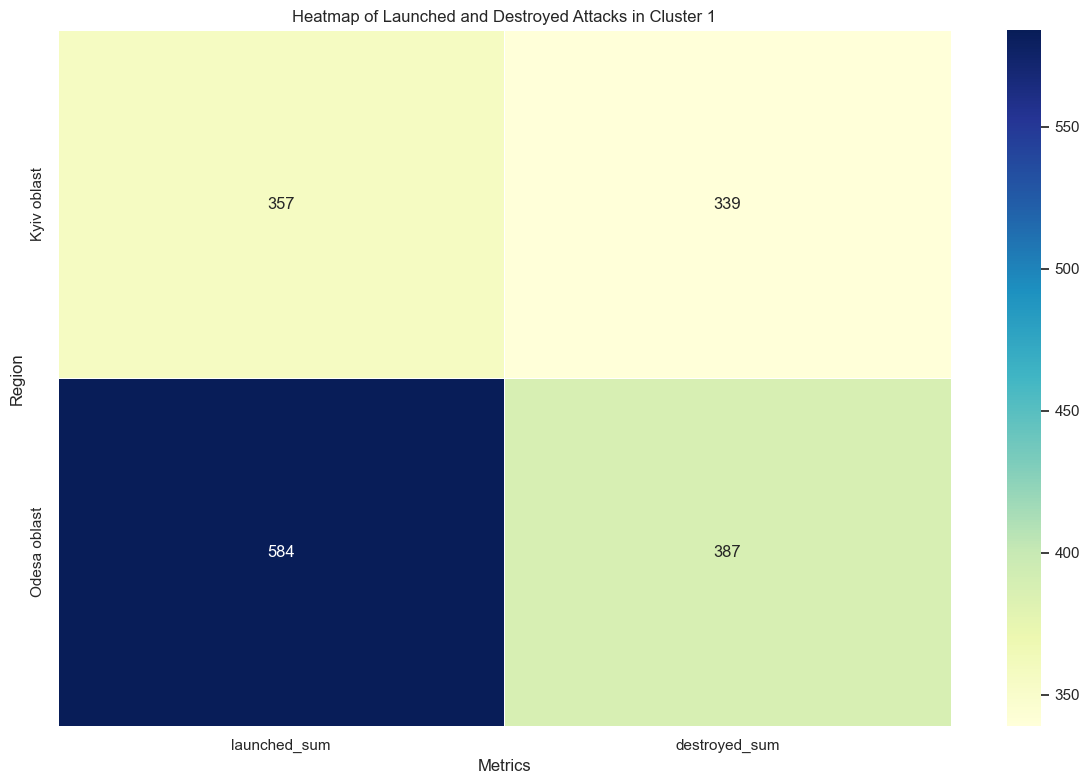

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the regions in Cluster 1
cluster_1 = region_features[region_features['cluster'] == 1]

# Select relevant columns for the heatmap
heatmap_data = cluster_1[['target', 'launched_sum', 'destroyed_sum']].set_index('target')

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.0f', cbar=True, linewidths=0.5)

plt.title('Heatmap of Launched and Destroyed Attacks in Cluster 1')
plt.xlabel('Metrics')
plt.ylabel('Region')
plt.tight_layout()
plt.show()


C:\Users\sonny bell\AppData\Local\Temp\ipykernel_20668\3498821990.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_1_sorted, x='launched_sum', y='target', palette='Reds_r')


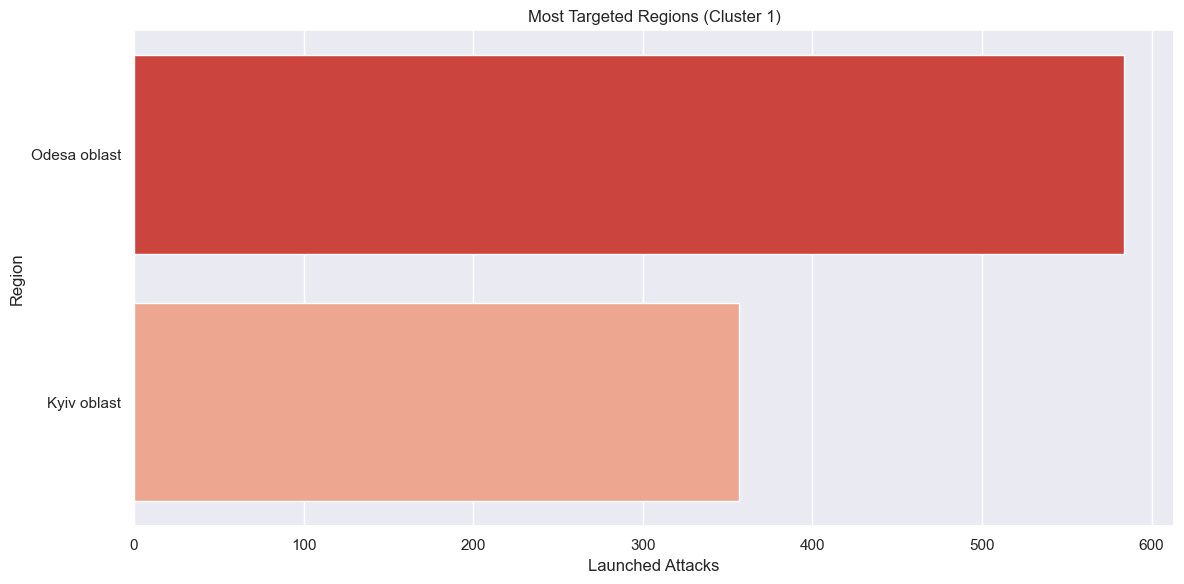

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter cluster 1
cluster_1 = region_features[region_features['cluster'] == 1]

# Sort by launched_sum
cluster_1_sorted = cluster_1.sort_values(by='launched_sum', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_1_sorted, x='launched_sum', y='target', palette='Reds_r')

plt.title('Most Targeted Regions (Cluster 1)')
plt.xlabel('Launched Attacks')
plt.ylabel('Region')
plt.tight_layout()
plt.show()


## Now lets try and predict unkown values using what was learnt from random forest

In [110]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Re define features and labels
features = [
    'launched_mean', 'launched_sum', 'launched_count',
    'destroyed_mean', 'destroyed_sum', 'destroyed_launch_ratio'
]

X = region_features[features]
y = region_features['cluster']

# Apply SMOTE
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("Resampled class distribution:")
print([pd.Series(y_resampled).value_counts()])

Resampled class distribution:
[cluster
0    81
1    81
Name: count, dtype: int64]


In [112]:


# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled, random_state=42)

# Train
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))


Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        20

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



In [118]:
scores = cross_val_score(clf, X_resampled, y_resampled, cv=5)
print("Average CV Accuracy: %.2f (+/- %.2f)" % (scores.mean(), scores.std()))

Average CV Accuracy: 1.00 (+/- 0.00)


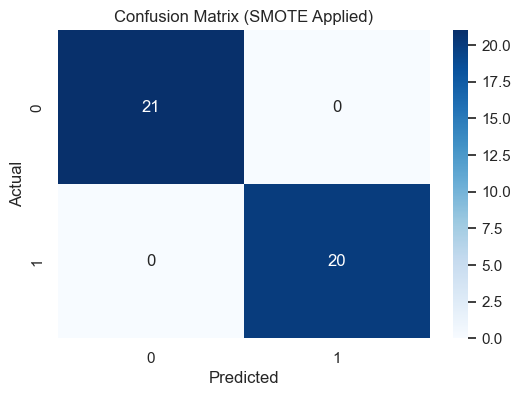

In [113]:


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (SMOTE Applied)")
plt.show()


In [128]:
# Predict current or new region features
region_features['predicted_cluster'] = clf.predict(region_features[[
    'launched_mean', 'launched_sum', 'launched_count',
    'destroyed_mean', 'destroyed_sum', 'destroyed_launch_ratio'
]])

# Show only the highest risk group (e.g., Cluster 1)
high_risk = region_features[region_features['predicted_cluster'] == 1]
high_risk_sorted = high_risk.sort_values(by='launched_sum', ascending=False)

print(high_risk_sorted[['target', 'launched_sum', 'destroyed_sum', 'predicted_cluster']])


          target  launched_sum  destroyed_sum  predicted_cluster
61  Odesa oblast         584.0          387.0                  1
47   Kyiv oblast         357.0          339.0                  1


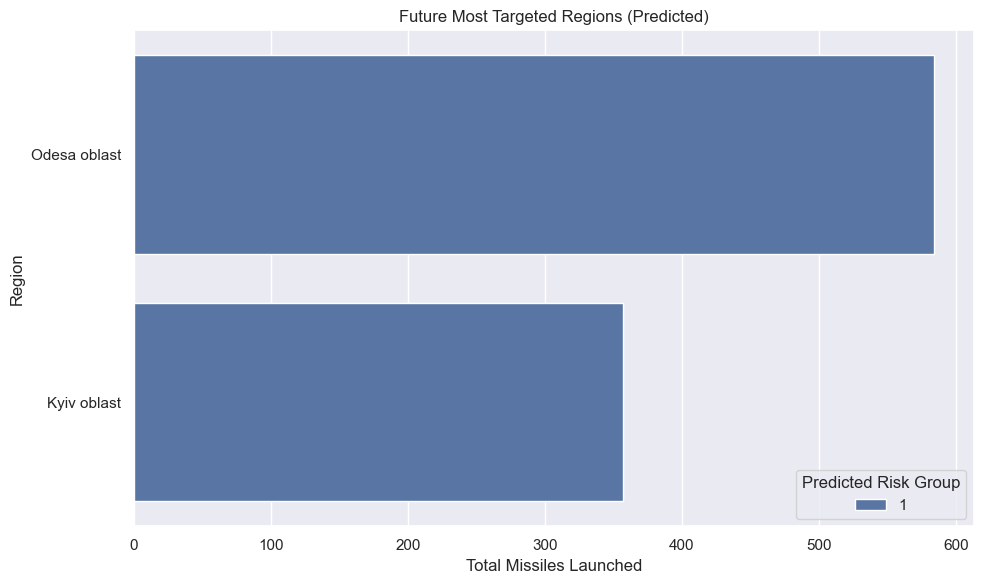

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=high_risk_sorted, x='launched_sum', y='target', hue='predicted_cluster')
plt.title("Future Most Targeted Regions (Predicted)")
plt.xlabel("Total Missiles Launched")
plt.ylabel("Region")
plt.legend(title="Predicted Risk Group")
plt.tight_layout()
plt.show()


In [131]:
region_features.describe()


,launched_mean,launched_sum,launched_count,destroyed_mean,destroyed_sum,destroyed_launch_ratio,cluster,predicted_cluster
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,8.395490,39.060241,10.433735,5.610159,26.951807,0.545225,0.024096,0.024096
std,10.627964,83.737737,26.888747,7.880929,62.633254,0.325304,0.154281,0.154281
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.067708,5.000000,1.000000,0.900000,1.500000,0.261364,0.000000,0.000000
50%,4.000000,14.000000,2.000000,2.000000,6.000000,0.666667,0.000000,0.000000
75%,7.857143,30.000000,5.500000,6.607143,23.000000,0.800000,0.000000,0.000000
max,55.333333,584.000000,159.000000,33.333333,387.000000,0.968750,1.000000,1.000000


In [141]:


smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(Counter(y_resampled))  # Now it should be balanced


Counter({0: 81, 1: 81})


In [143]:
simulated_future = pd.DataFrame({
    'launched_mean': np.random.uniform(50, 800, 10),
    'launched_sum': np.random.uniform(100, 2000, 10),
    'launched_count': np.random.randint(1, 20, 10),
    'destroyed_mean': np.random.uniform(20, 700, 10),
    'destroyed_sum': np.random.uniform(50, 1800, 10)
})
simulated_future['destroyed_launch_ratio'] = simulated_future['destroyed_sum'] / (simulated_future['launched_sum'] + 1)


In [148]:
import numpy as np
import pandas as pd

# Simulate 10 regions with random plausible values
simulated_X = pd.DataFrame({
    'launched_mean': np.random.uniform(150, 500, 10),
    'launched_sum': np.random.uniform(300, 1000, 10),
    'launched_count': np.random.randint(1, 10, 10),
    'destroyed_mean': np.random.uniform(100, 400, 10),
    'destroyed_sum': np.random.uniform(200, 900, 10),
})

# Add ratio feature
simulated_X['destroyed_launch_ratio'] = simulated_X['destroyed_sum'] / (simulated_X['launched_sum'] + 1)


In [144]:
simulated_future['predicted_cluster'] = clf.predict(simulated_future)


In [121]:
import joblib
joblib.dump(clf, 'region_risk_model.pkl')


['region_risk_model.pkl']

In [122]:
clf = joblib.load('region_risk_model.pkl')


In [1]:
kmeans_dataset.info()

NameError: name 'kmeans_dataset' is not defined